In [1]:
# --------------------------------------------
# 0. Imports & misc. helpers
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from experiment_config import config
from pathlib import Path
from collections import Counter
from tqdm import tqdm

from dataloader_cls import get_data_loader

sns.set_style("whitegrid")

def make_weights_for_balanced_classes(labels: np.ndarray) -> torch.DoubleTensor:
    """Per‑sample weights so the sampler draws benign/malignant equally."""
    n = len(labels)
    _, counts = np.unique(labels, return_counts=True)
    # frac = {cls: n / c for cls, c in zip(*np.unique(labels, return_counts=True))}
    frac = {cls: (n / c) * (10.0 if cls == 1 else 1.0) for cls, c in zip(*np.unique(labels, return_counts=True))}
    return torch.DoubleTensor([frac[l] for l in labels])
    
# --------------------------------------------
# Load your CSVs and data-loaders (as before)
# --------------------------------------------
train_df = pd.read_csv(config.CSV_DIR_TRAIN)
valid_df = pd.read_csv(config.CSV_DIR_VALID)

sampler = torch.utils.data.WeightedRandomSampler(
    make_weights_for_balanced_classes(train_df.label.values),
    len(train_df),
)
common_loader_args = dict(
        workers=config.NUM_WORKERS,
        batch_size=config.BATCH_SIZE,
        size_mm=config.SIZE_MM,
        size_px=config.SIZE_PX,
    )
train_loader = get_data_loader(
    config.DATADIR,
    train_df,
    mode="3D",
    sampler=sampler,
    rotations=config.ROTATION,
    translations=config.TRANSLATION,
    use_monai_transforms=True,
    **common_loader_args,
)
valid_loader = get_data_loader(
    config.DATADIR,
    valid_df,
    mode="3D",
    rotations=None,
    translations=None,
    use_monai_transforms=False,
    **common_loader_args,
)

# --------------------------------------------
# 1. Fast metadata comparison (CSV only)
# --------------------------------------------
def summarize_csv(df, name="train"):
    print(f"📊  ==== {name.upper()} SUMMARY ====")
    print(f"Rows (patches):        {len(df):,}")
    print(f"Unique patients:       {df.PatientID.nunique():,}")
    print(f"Lesions (NoduleID):    {df.NoduleID.nunique():,}")
    print("\nLabel distribution:")
    display(
        df.label.value_counts().to_frame("count")
          .assign(frac=lambda x: x["count"] / x["count"].sum())
          .style.format({"frac": "{:.1%}"})
    )

summarize_csv(train_df, "train")
summarize_csv(valid_df, "valid")

# Patient overlap check
overlap = set(train_df.PatientID) & set(valid_df.PatientID)
print(
    f"\n⚠️  Patient overlap between splits: {len(overlap)} "
    f"({','.join(list(overlap)[:10]) + ('...' if len(overlap)>10 else '')})"
)


📊  ==== TRAIN SUMMARY ====
Rows (patches):        4,948
Unique patients:       1,696
Lesions (NoduleID):    2,990

Label distribution:


,count,frac
label,,
0,4502,91.0%
1,446,9.0%


📊  ==== VALID SUMMARY ====
Rows (patches):        1,215
Unique patients:       424
Lesions (NoduleID):    772

Label distribution:


,count,frac
label,,
0,1106,91.0%
1,109,9.0%



⚠️  Patient overlap between splits: 0 ()


📊  ==== TRAIN SUMMARY ====
Rows (patches):        4,948
Unique patients:       1,696
Lesions (NoduleID):    2,990

Label distribution:


,count,frac
label,,
0,4502,91.0%
1,446,9.0%


📊  ==== VALID SUMMARY ====
Rows (patches):        1,215
Unique patients:       424
Lesions (NoduleID):    772

Label distribution:


,count,frac
label,,
0,1106,91.0%
1,109,9.0%



⚠️  Patient overlap between splits: 0 ()


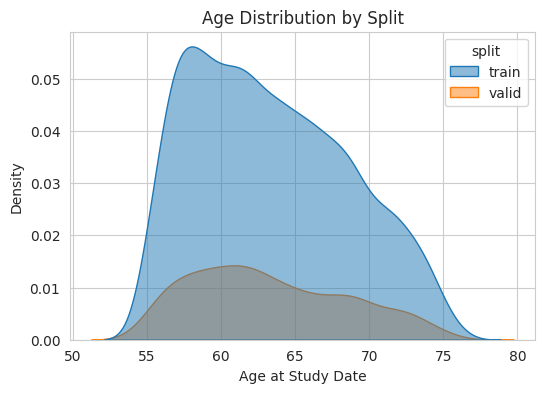

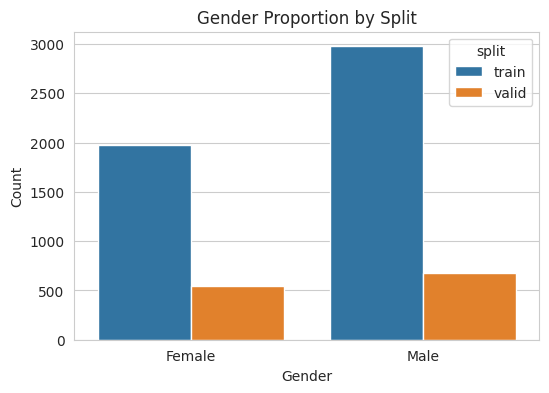

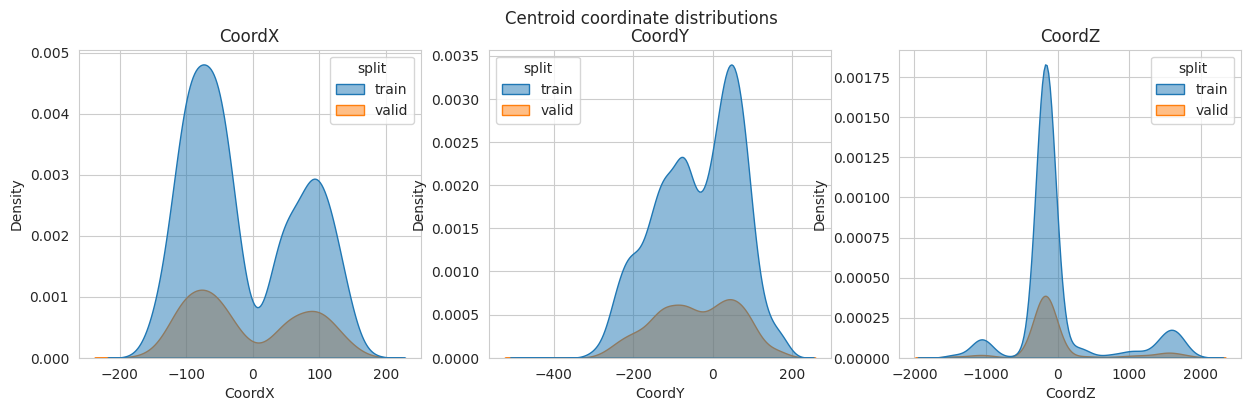

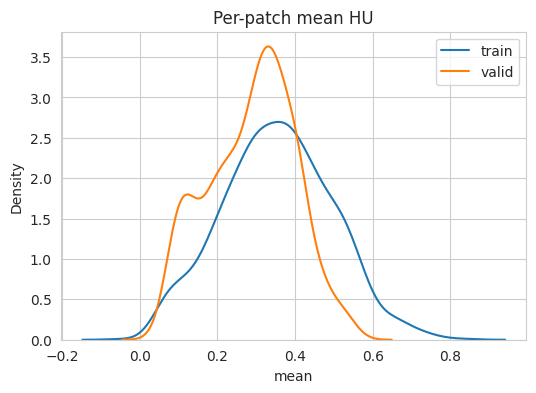

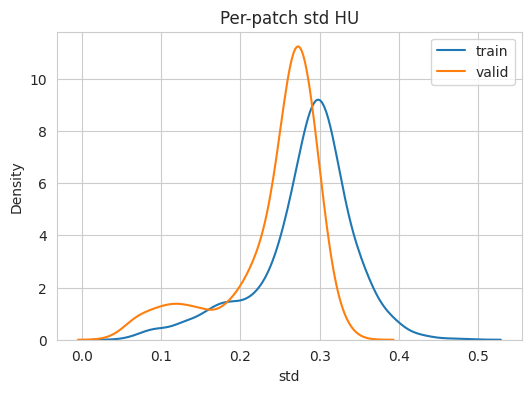

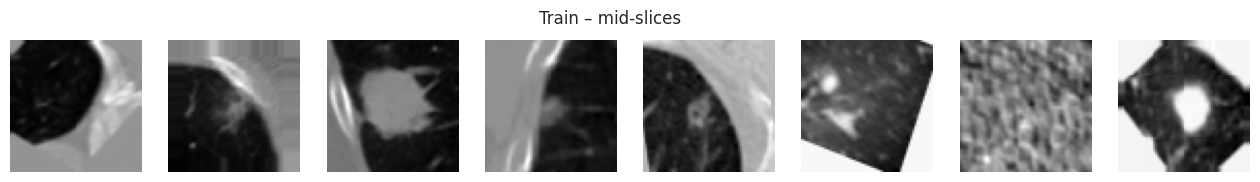

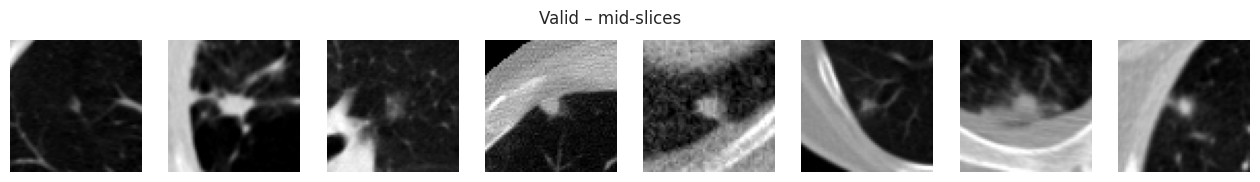

In [4]:

# --------------------------------------------
# 1b. Age & gender distributions, corrected
# --------------------------------------------
# Tag each DF and concatenate
train_df["split"] = "train"
valid_df["split"] = "valid"
ag = pd.concat([train_df, valid_df], ignore_index=True)

# KDE of age
plt.figure(figsize=(6,4))
sns.kdeplot(data=ag, x="Age_at_StudyDate", hue="split", fill=True, alpha=0.5)
plt.title("Age Distribution by Split")
plt.xlabel("Age at Study Date")
plt.ylabel("Density")
plt.show()

# Bar plot of gender
plt.figure(figsize=(6,4))
sns.countplot(data=ag, x="Gender", hue="split")
plt.title("Gender Proportion by Split")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Nod­ule centroid comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, coord in enumerate(["CoordX", "CoordY", "CoordZ"]):
    sns.kdeplot(data=ag, x=coord, hue="split", fill=True, alpha=0.5, ax=ax[i])
    ax[i].set_title(coord)
fig.suptitle("Centroid coordinate distributions")
plt.show()

# --------------------------------------------
# 2. Patch-level voxel statistics
# --------------------------------------------
def patch_stats(loader, max_batches=50):
    """Return list of per-patch mean & std for ~max_batches batches."""
    means, stds = [], []
    with torch.no_grad():
        for b, batch in enumerate(loader):
            img = batch["image"].float()   # (B,1,64,64,64)
            means.extend(img.mean(dim=(1,2,3,4)).cpu().numpy())
            stds.extend(img.std (dim=(1,2,3,4)).cpu().numpy())
            if b >= max_batches:
                break
    return pd.DataFrame({"mean": means, "std": stds})

train_stats = patch_stats(train_loader)
valid_stats = patch_stats(valid_loader)

plt.figure(figsize=(6,4))
sns.kdeplot(train_stats["mean"], label="train")
sns.kdeplot(valid_stats["mean"], label="valid")
plt.title("Per-patch mean HU")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(train_stats["std"], label="train")
sns.kdeplot(valid_stats["std"], label="valid")
plt.title("Per-patch std HU")
plt.legend()
plt.show()




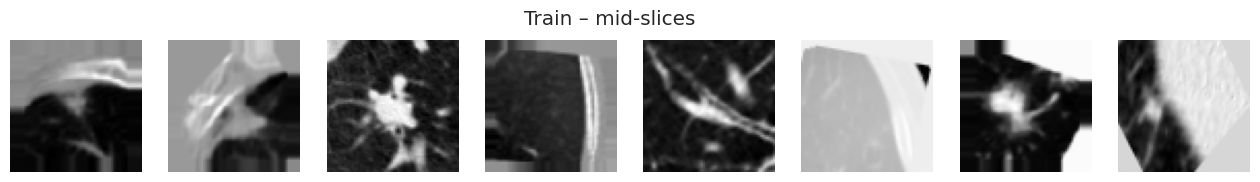

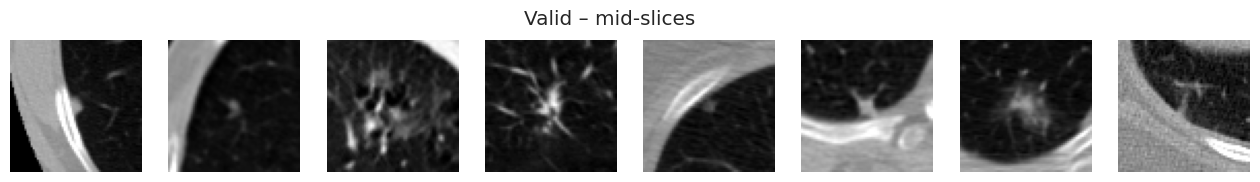

In [12]:
# --------------------------------------------
# 3. Quick visual sanity check (montage)
# --------------------------------------------
def show_random_patches(loader, n=8, title=""):
    imgs = []
    for batch in loader:
        imgs.extend(batch["image"][:n].cpu().numpy())
        if len(imgs) >= n:
            break
    imgs = np.stack(imgs)[:n]           # (n,1,D,H,W)
    mid = imgs.shape[2] // 2            # axial mid-slice
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i, 0, mid], cmap="gray")
        ax.axis("off")
    fig.suptitle(title)
    plt.show()

show_random_patches(train_loader, title="Train – mid-slices")
show_random_patches(valid_loader, title="Valid – mid-slices")

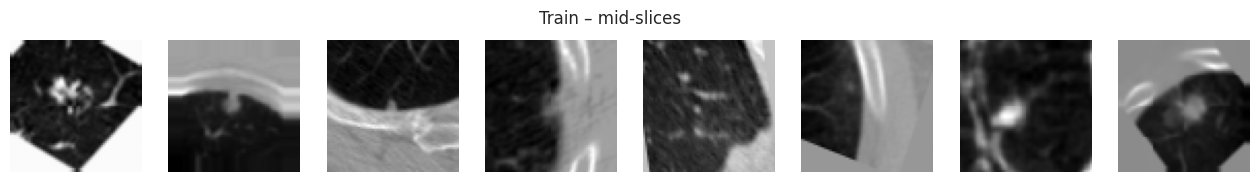

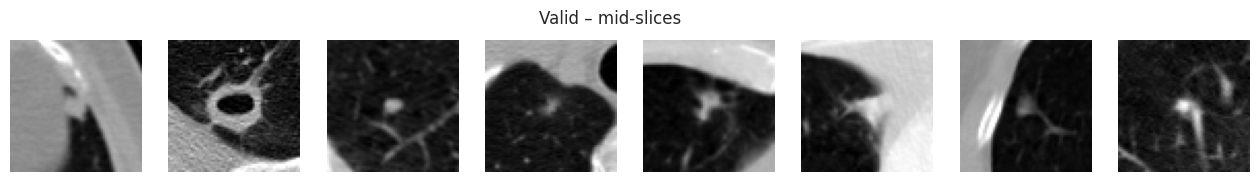

In [5]:
show_random_patches(train_loader, title="Train – mid-slices")
show_random_patches(valid_loader, title="Valid – mid-slices")

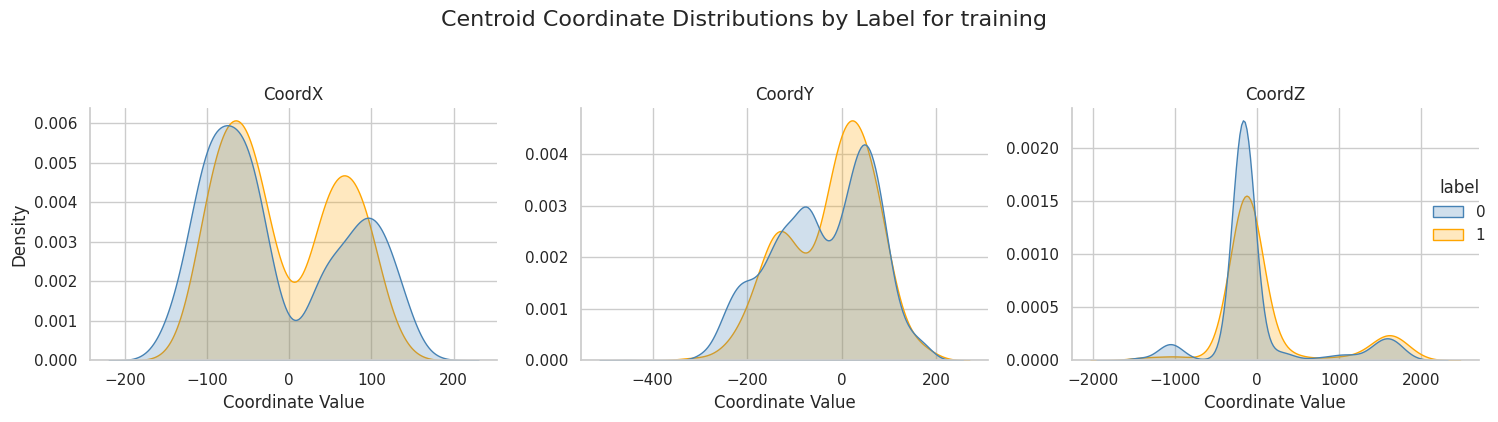

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: adjust plot style
sns.set(style="whitegrid")

# --------------------------------------------
# Load your CSVs and data-loaders (as before)
# --------------------------------------------
train_df = pd.read_csv(config.CSV_DIR_TRAIN)
valid_df = pd.read_csv(config.CSV_DIR_VALID)

df = train_df
# Melt the coordinate columns for easier plotting
df_melted = df.melt(id_vars=["label"], value_vars=["CoordX", "CoordY", "CoordZ"],
                    var_name="Axis", value_name="Coordinate")

# Create the density plots
g = sns.displot(
    data=df_melted,
    x="Coordinate",
    col="Axis",
    hue="label",
    kind="kde",
    common_norm=False,
    fill=True,
    facet_kws={'sharey': False, 'sharex': False},
    height=4,
    aspect=1.2,
    palette={0: "steelblue", 1: "orange"},
)

g.set_titles("{col_name}")
g.set_axis_labels("Coordinate Value", "Density")
g.fig.suptitle("Centroid Coordinate Distributions by Label for training", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


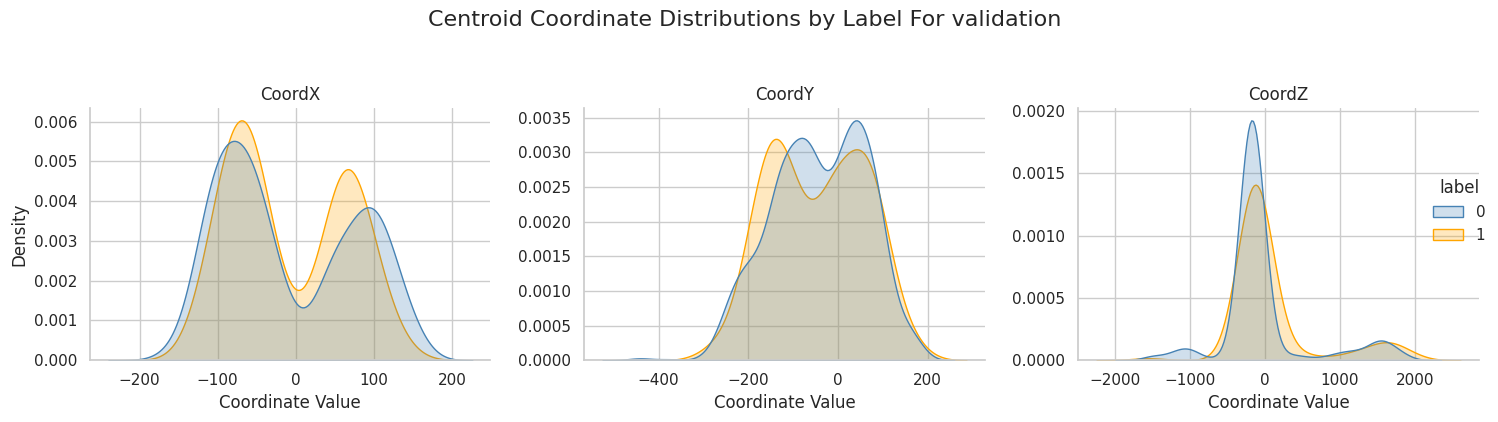

In [10]:
df = valid_df
# Melt the coordinate columns for easier plotting
df_melted = df.melt(id_vars=["label"], value_vars=["CoordX", "CoordY", "CoordZ"],
                    var_name="Axis", value_name="Coordinate")

# Create the density plots
g = sns.displot(
    data=df_melted,
    x="Coordinate",
    col="Axis",
    hue="label",
    kind="kde",
    common_norm=False,
    fill=True,
    facet_kws={'sharey': False, 'sharex': False},
    height=4,
    aspect=1.2,
    palette={0: "steelblue", 1: "orange"},
)

g.set_titles("{col_name}")
g.set_axis_labels("Coordinate Value", "Density")
g.fig.suptitle("Centroid Coordinate Distributions by Label For validation", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


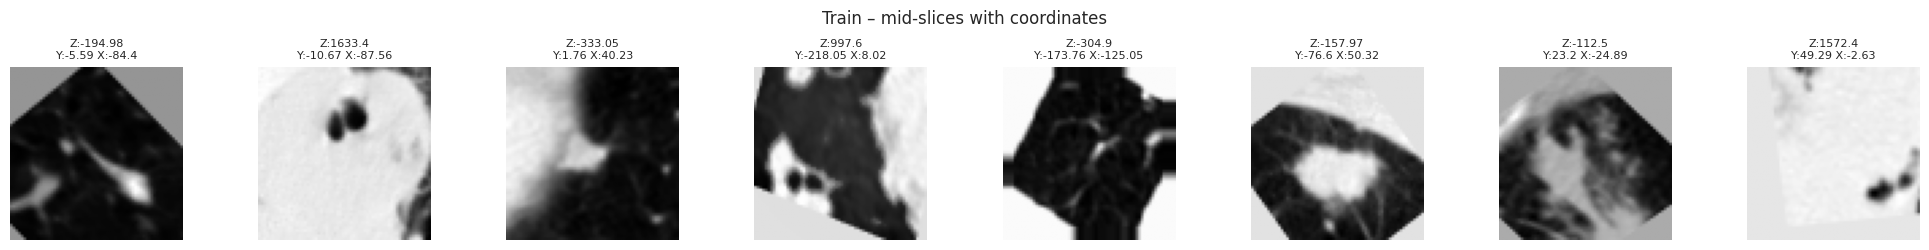

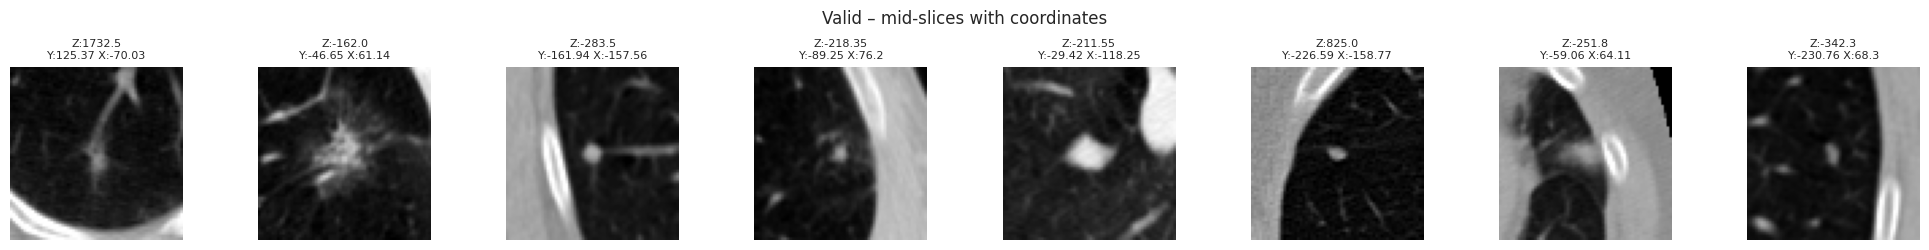

In [2]:
def show_random_patches_with_coords(loader, n=8, title=""):
    imgs = []
    coords = []
    
    for batch in loader:
        batch_imgs = batch["image"][:n].cpu().numpy()
        origins = batch["origin"][:n]      # (z, y, x)
        spacings = batch["spacing"][:n]    # voxel spacing (dz, dy, dx)

        for i in range(len(batch_imgs)):
            imgs.append(batch_imgs[i])
            origin = origins[i]
            spacing = spacings[i]
            # Convert origin to physical coordinate (if needed), or just collect as-is
            coords.append(tuple(np.round(origin, 2)))

        if len(imgs) >= n:
            break

    imgs = np.stack(imgs)[:n]     # (n,1,D,H,W)
    coords = coords[:n]
    mid = imgs.shape[2] // 2      # axial mid-slice

    fig, axs = plt.subplots(1, n, figsize=(n * 2.5, 2.5))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i, 0, mid], cmap="gray")
        ax.axis("off")
        z, y, x = coords[i]
        ax.set_title(f"Z:{z}\nY:{y} X:{x}", fontsize=8)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
show_random_patches_with_coords(train_loader, title="Train – mid-slices with coordinates")
show_random_patches_with_coords(valid_loader, title="Valid – mid-slices with coordinates")


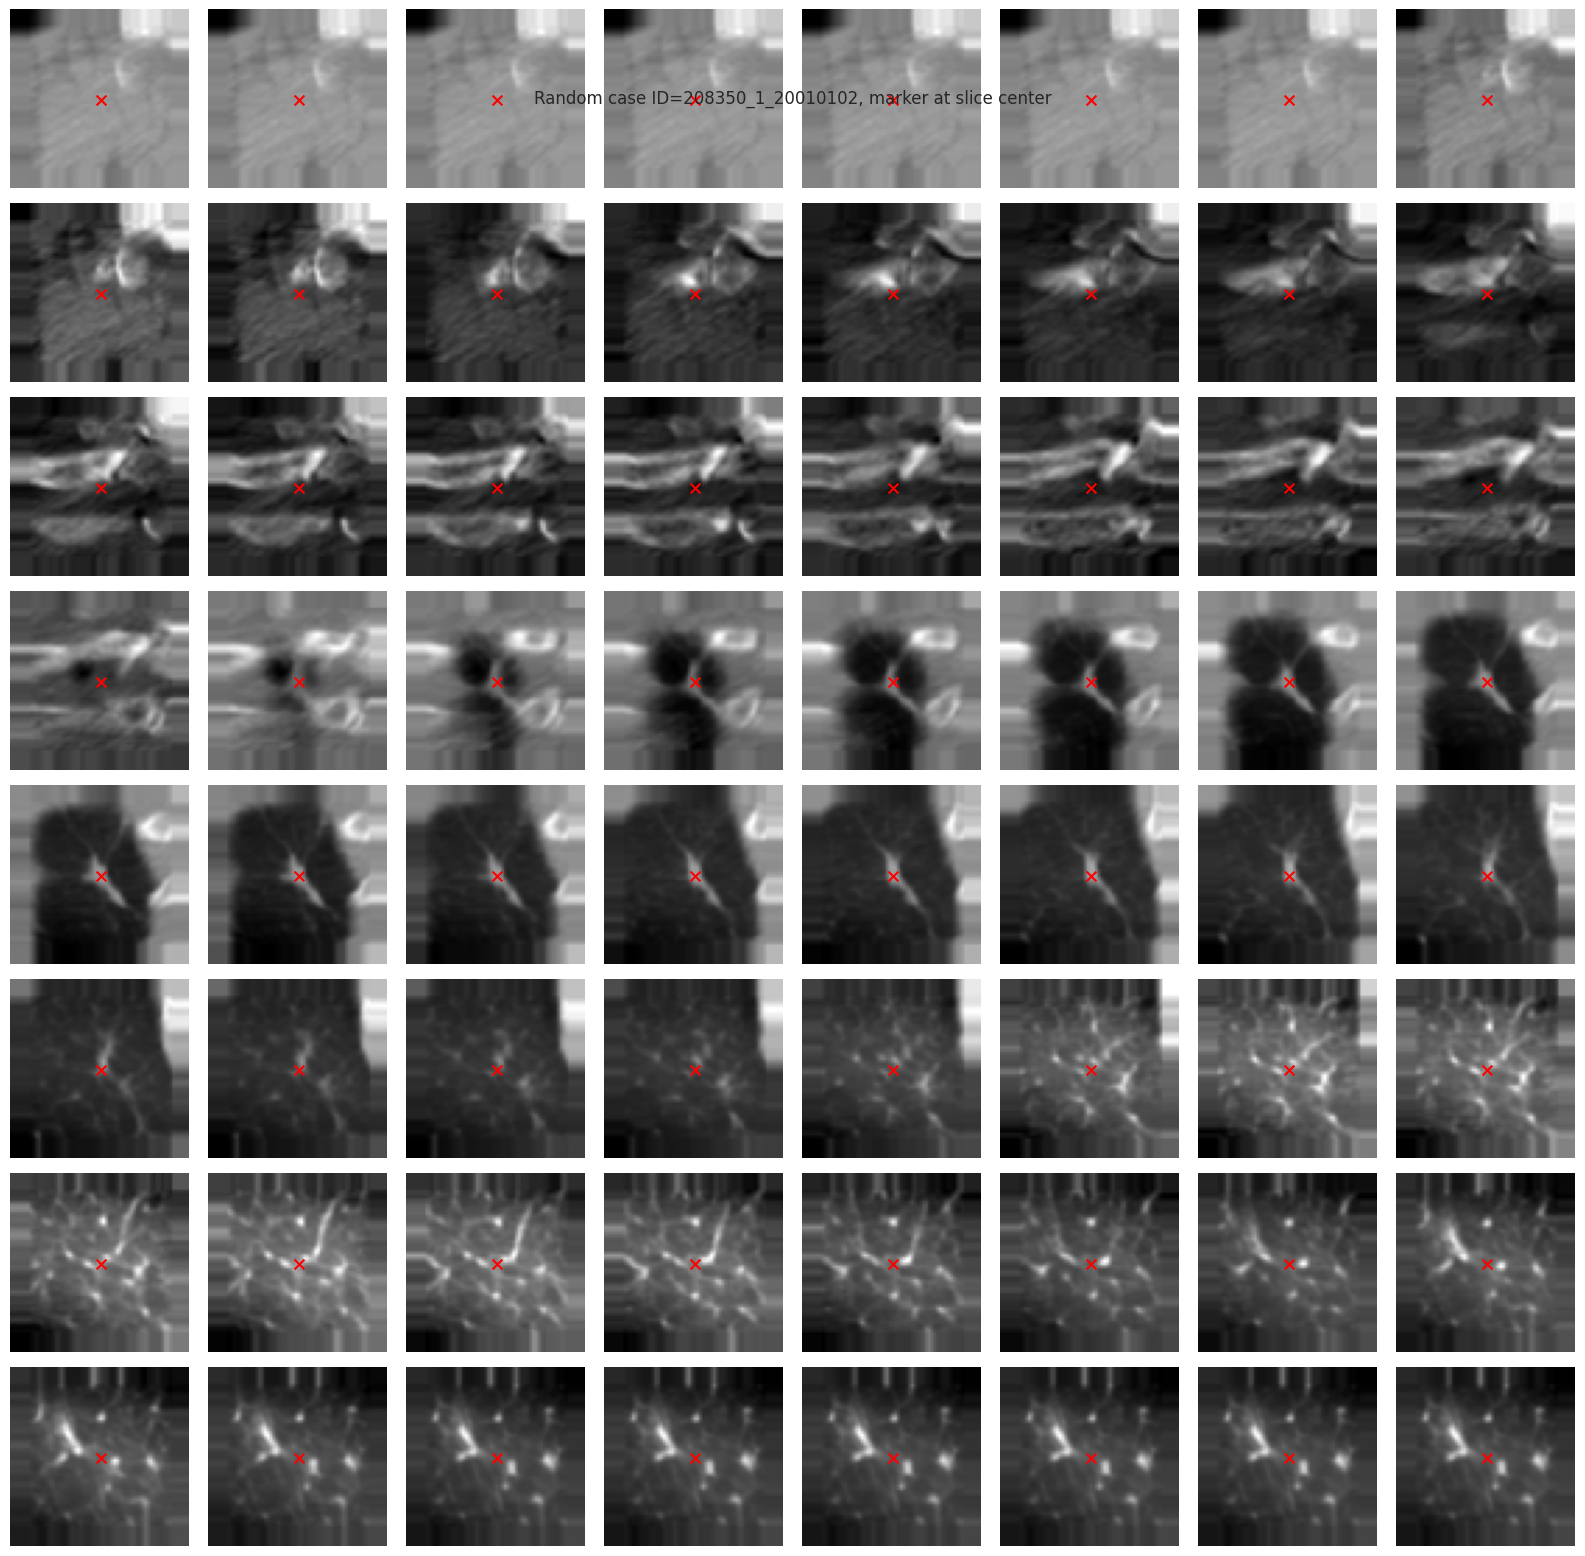

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def show_random_patch_with_red_marker(loader, n_cols=8):
    """
    Picks one random sample from loader.dataset (a CTCaseDataset),
    plots all axial slices in an n_cols x n_rows grid,
    and places a red marker at the tumor center on each slice.
    """
    ds = loader.dataset
    # choose a random index in the dataset
    idx = np.random.randint(len(ds))
    sample = ds[idx]
    
    # patch: shape (1, Z, Y, X)
    patch = sample["image"]
    vol = patch[0]  # shape (Z, Y, X)
    n_slices, height, width = vol.shape
    
    # tumor center is at the center of the patch
    cy, cx = height / 2, width / 2
    
    # prepare the grid
    n_rows = int(np.ceil(n_slices / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()
    
    for i in range(n_slices):
        ax = axes[i]
        ax.imshow(vol[i], cmap="gray")
        ax.axis("off")
        # place red marker at the center of the patch
        ax.scatter([cx], [cy], marker='x', s=50, color='red')
    
    # turn off any unused subplots
    for j in range(n_slices, len(axes)):
        axes[j].axis("off")
    
    orig_id = sample["ID"]
    plt.suptitle(f"Random case ID={orig_id}, marker at slice center", y=0.92)
    plt.tight_layout()
    plt.show()
show_random_patch_with_red_marker(train_loader)